# Preliminary Simulation Analysis

In [5]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 300

In [10]:
# Function to read in halo properties
def loadProperties(catalogue):
    soap = h5py.File(catalogue, 'r') # Read in SOAP property file
    mtotal = np.array(soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
    mstar = np.array(soap['ExclusiveSphere/30kpc/StellarMass'])

    # If you want to mask for field haloes only (host halos only)
    #field = np.array(soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
    #m200 = m200[field==-1]
    #mstar = mstar[field==-1]

    return mtotal, mstar

# function to read in bound DM particles for a given halo
def getHaloDarkMatterMembers(snapshot, membership_fil, halo_i):
    #halo INDEX is not halo ID
    # function to read in bound DM particles for a given halo
    members = h5py.File(membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
    bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

    data = sw.load(snapshot) # Load snapshot data
    positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    positions = positions[bound_particles] # Mask for particles bound to given halo

    return positions

def getHaloStarsMembers(snapshot, membership_file, halo_i):
    members = h5py.File(membership_file, 'r') # Membership data
    host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
    bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

    data = sw.load(snapshot) # Load snapshot data
    positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
    star_positions = positions[bound_particles] # Mask for particles bound to given halo

    return star_positions

## Get general properties

In [11]:
SOAP_fname = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_halo_properties_0063.hdf5'
SOAP_membership = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/SOAP_membership_0063.hdf5'
snapshot = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume15/snapshot_0063.hdf5'
halo = 5 # Example

soap = h5py.File(SOAP_fname, 'r') # Read in SOAP property file
members = h5py.File(SOAP_membership, 'r')
mtotal, mstar = loadProperties(SOAP_fname)
stars_positions = getHaloStarsMembers(snapshot, SOAP_membership, halo)
field = np.array(soap['VR/HostHaloID'])

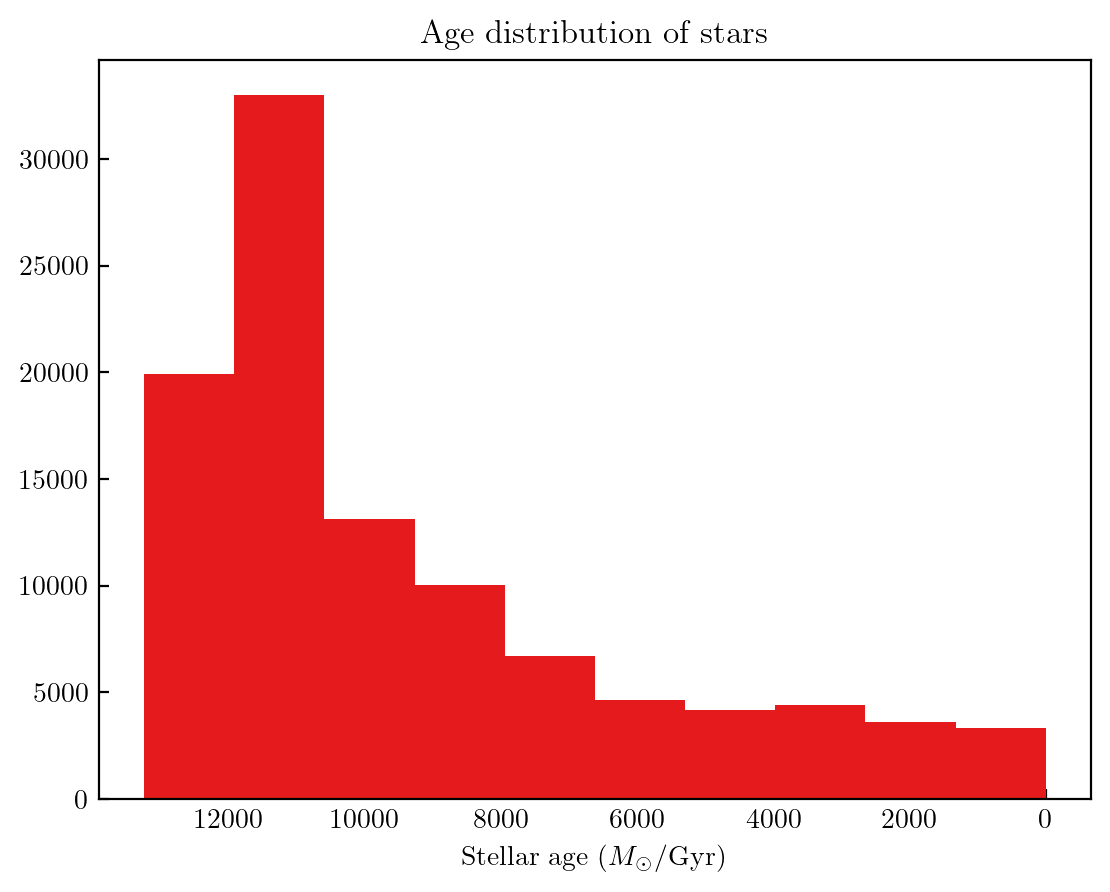

In [12]:
data = sw.load(snapshot)
#print(data.metadata.stars_properties.field_names)
time = np.cumsum(data.stars.timestep*977.79) #Gyr comoving
birth_scale_factor = data.stars.birth_scale_factors
plt.figure(dpi=200)
mass = np.array(data.stars.masses*10000000000.0)
age = np.array(data.stars.ages*977.79)
dmdt = mass/age
plt.hist(age) #convert to stellar mass by time instead of number by scale factor
#plt.scatter(masses, age, s = 1, alpha = 0.01)
plt.xlabel(r'Stellar age ($M_{\odot}$/Gyr)')
#plt.xscale('log')
plt.gca().invert_xaxis()
plt.title('Age distribution of stars')
plt.show()

## Suggested explorations for LMC objects:
- Star formation histories (easy)
- Stellar Mass function (easy)
- Baryonic component of LMCs
    - Gas rich? Rotating?
    - Metallicity

In [21]:
# see biggest objects to look at satellites (smaller ones won't have satellites) (LMC, stellar mass 10^9) how can we get satellites?

# volume 15 might have larger objects

#particle type 4 is stars

#particles type 0 is gas

#type 1 is DM, type 2 is background DM (low res)

#SANITY CHECK: plot stellar mass (mstar and/or total mass) vs distance to host once satellites are found. Distance should not be more than 100-200kpc

#Velocity dispersion in stars (part type 4, so 6 columns one for each part type)
#dispersion is total over every direction

In [6]:
#_i is always index from the catalogue, 
#and _ids is id from the catalogue

class SimToolsPlotting():
    def __init__(self, folder_path):
        # Initialize by reading and combining CSV files
        if folder_path.endswith('.csv'):
            main_df = pd.read_csv(folder_path, converters={'Host CoM':pd.eval, 'Host CoMV':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})
            self.main_df = main_df
        else:
            self.main_df = self.read_and_combine_csvs(folder_path)
        self.vol = self.get_volume_number(self.main_df)
        self.mtotal = np.array(list(self.main_df['Host Mtot']) + [val for sublist in self.main_df['Sat Mtot'] for val in sublist])
        self.mstar = np.array(list(self.main_df['Host M*']) + [val for sublist in self.main_df['Sat M*'] for val in sublist])
        self.sat_cols = ['Sat CoM', 'Sat ID', 'Sat M*', 'Sat Mtot', 'Sat i', 'Sat Mhyd', 'Sat Mgas', 'Sat HalfM* radius', 'Sat M* Metal', 'Sat M* Iron', 'Sat vel', 'Sat Vmax', 'Sat CoMV']

    def get_volume_number(self, df):
        if 'Volume' in df.columns:
            return df['Volume'].iloc[0]
        else:
            raise ValueError("Volume number column not found in dataframe")

    def read_and_combine_csvs(self, folder_path):
        # Initialize an empty list to store the dataframes
        dfs = []

        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                # Read each CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), converters={
                    'Host CoM': pd.eval, 'Host CoMV': pd.eval, 'Sat ID': pd.eval, 'Sat i': pd.eval, 'Sat Mtot': pd.eval, 'Sat M*': pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
                    'Sat Mgas': pd.eval, 'Sat HalfM* radius': pd.eval, 'Sat M* Metal': pd.eval, 'Sat M* Iron': pd.eval, 'Sat vel': pd.eval, 'Sat Vmax': pd.eval, 'Sat CoMV': pd.eval
                })
                # Append the dataframe to the list
                dfs.append(df)

        # Concatenate all dataframes in the list
        combined_df = pd.concat(dfs, ignore_index=True)
        
        return combined_df
    
    def getCentralHalos(self, distance_cut=True, dist_from_center = 5):
        center = np.array([float(c) for c in centers.loc[self.vol]])

        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        self.center_distance_mask = []
        for i in central_df['Host i']:
            val = all(np.abs(central_df['Host CoM'].loc[i]-center) < dist_from_center)
            self.center_distance_mask.append(val)

        self.central_df = central_df.loc[self.center_distance_mask]

        if distance_cut:
            for i in self.central_df['Host i']:
                # Distance cut of satellites
                r200 = self.central_df['Host R200'].loc[i]
                host_center = np.array(self.central_df['Host CoM'].loc[i])
                satellite_centers = self.central_df['Sat CoM'].loc[i]
                distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000
                distance_mask = distances < r200
                for col in self.sat_cols:
                    self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()
        else:
            pass

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], c=clrs[1], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])), bins='freedman')
        axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])), bins='freedman')
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'b','--')
        fig.suptitle('Host Halo mass distributions')
        fig.show()

    def number_plots(self, mstar_cut=True):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        central_df = self.central_df.copy(deep=True)

        # Do mass cut of all satellite halos if mass_cut=True
    
        for i in self.central_df['Host i']:
            mtot_mask = np.array(self.central_df['Sat Mtot'].loc[i]) > 1e7
            mstar_mask = np.array(self.central_df['Sat M*'].loc[i]) > 1e5
            for col in self.sat_cols:
                if mstar_cut:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask & mstar_mask]
                else:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            arrays = {
                'Radial Distance': distances,
                'Normalized Radial Distance': distances / r200,
                'Stellar Mass': central_df['Sat M*'].loc[i], 
                'Normalized Stellar Mass': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
                'Total Mass': central_df['Sat Mtot'].loc[i], 
                'Normalized Total Mass': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'Radial Distance' or key == 'Normalized Radial Distance':
                    y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                host_id = self.central_df.loc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[2].set_ylabel(r'$N(>M^{*})$')
        #ax_flat[2].set_yscale('log')
        
        ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
        #ax_flat[3].set_yscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[4].set_xscale('log')
        
        ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Individual Central halo satellite properties for Vol. {self.vol}')

        plt.show()

    def avg_number_plots(self, mstar_cut=True):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'Radial Distance': [],
            'Normalized Radial Distance': [],
            'Stellar Mass': [], 
            'Normalized Stellar Mass': [], 
            'Total Mass': [], 
            'Normalized Total Mass': []
        }
        central_df = self.central_df.copy(deep=True)

    
        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        mstar_mask = [np.array(self.central_df['Sat M*'].loc[i]) > 1e5 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                if mstar_cut:
                    central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i] & mstar_mask[i]]
                    

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['Radial Distance'].append(distances)
            arrays['Normalized Radial Distance'].append(distances / r200)
            arrays['Stellar Mass'].append(sat_mstar)
            arrays['Total Mass'].append(sat_mtot)
            arrays['Normalized Stellar Mass'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['Normalized Total Mass'].append(sat_mtot / central_df.loc[i]['Host Mtot'])
            
        # Loop over the first 6 keys in the arrays dictionary
        for j, key in enumerate(list(arrays.keys())):
            arrays[key] = np.concatenate(arrays[key])
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'Radial Distance' or key == 'Normalized Radial Distance':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)
                y_values = y_values / len(central_df)

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-')
            ax_flat[j].set_title(key)

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[2].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[2].set_ylabel(r'$N(>M^{*})$')
        #ax_flat[2].set_yscale('log')
        
        ax_flat[3].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')
        #ax_flat[3].set_yscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[4].set_xscale('log')
        
        ax_flat[5].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Central halo satellite properties for Vol. {self.vol}')

        plt.show()

    def lum_nonlum_number_plots(self):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'Radial Distance': [],
            'Normalized Radial Distance': [],
            'Total Mass': [],
            'Normalized Total Mass': [],
            'Stellar Mass': [],  
            'Normalized Stellar Mass': []
        }
        central_df = self.central_df.copy(deep=True)

        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['Radial Distance'].append(distances)
            arrays['Normalized Radial Distance'].append(distances / r200)
            arrays['Stellar Mass'].append(sat_mstar)
            arrays['Total Mass'].append(sat_mtot)
            arrays['Normalized Stellar Mass'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['Normalized Total Mass'].append(sat_mtot / central_df.loc[i]['Host Mtot'])

        non_zero_mask = np.concatenate([array != 0 for array in arrays['Stellar Mass']])

        for j, key in enumerate(list(arrays.keys())):
            if key in ['Radial Distance', 'Normalized Radial Distance']:
                arrays[key] = np.concatenate(arrays[key])

                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                #differentiate between luminous and non-luminous satellites here
                nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
                total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[5], label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, 'black', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            elif key in ['Total Mass', 'Normalized Total Mass']:
                arrays[key] = np.concatenate(arrays[key])
                
                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                nonzero_y_values = np.arange(1, len(nonzero_x_values)+1)/len(central_df)
                total_y_values = np.arange(1, len(total_x_values)+1)/len(central_df)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[5], label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, c='black', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            elif key in ['Stellar Mass', 'Normalized Stellar Mass']:
                mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['Stellar Mass']])
                mstar_conc = np.concatenate(arrays[key])[mstar_cut_mask]
                x_values_conc = sorted(mstar_conc, reverse=True)
                y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)

                ax_flat[j].plot(x_values_conc, y_values_conc, c=clrs[1], label='average')
                ax_flat[j].set_title(key)
                ax_flat[j].set_xscale('log')
                #Add the individual host plots:
                for i, array in enumerate(arrays[key]):
                    x_values = sorted(array[arrays['Stellar Mass'][i]>1e5], reverse=True)
                    y_values = np.arange(1, len(x_values) + 1)
                    ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')
            else:
                pass

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')
        
        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel(r'$N(<r200)/N_{\textrm{tot}}$')

        ax_flat[2].set_xlabel(r'$M^{\textrm{tot}}$ ($M_{\odot}$)')
        ax_flat[2].set_ylabel(r'$N(>M^{\textrm{tot}})$')
        ax_flat[2].set_xscale('log')
        
        ax_flat[3].set_xlabel(r'$M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'N($>M^\textrm{tot}/M^{\textrm{tot}}_{\textrm{host}}$)')
        ax_flat[3].set_xscale('log')
        
        ax_flat[4].set_xlabel(r'$M^{*} (M_\odot$)')
        ax_flat[4].set_ylabel(r'$N(>M^{*})$')
        
        ax_flat[5].set_xlabel(r'$M^{*}/M^{*}_{\textrm{host}}$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'$N(>M^{*}/M^{*}_{\textrm{host}})$')

        fig.suptitle(f'Luminous vs. All Satellites Properties for Central Halos in Vol {self.vol}')

        plt.show()

    def smhm_centralhalos(self):
        #make stellar mass hallo mass plots for each host and its respective satelites
        fig, ax = plt.subplots(dpi=150, constrained_layout=True)
        cmap = plt.get_cmap('Set1')
        for i in range(len(self.central_df['Host i'])):
            host_id = self.central_df['Host ID'].iloc[i]
            ax.scatter(self.central_df['Host Mtot'].iloc[i], self.central_df['Host M*'].iloc[i], s=20, color = cmap(i), label=f'Host {host_id}', marker='*')
            sat_mstar_array = np.array(self.central_df['Sat M*'].iloc[i])
            # Replace 0 values with 10^3.5
            sat_mstar_array[sat_mstar_array == 0.0] = 10**3.5
            ax.scatter(self.central_df['Sat Mtot'].iloc[i], sat_mstar_array, s=3, color = cmap(i), alpha = 0.5, label=f'Satellites {host_id}')
        ax.scatter(self.main_df['Host Mtot'], self.main_df['Host M*'], c='Gray', s=2, alpha=0.2)

        ax.set_xlabel('Total Mass')
        ax.set_ylabel('Stellar Mass')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        fig.suptitle(f'Central Halo SHMH Volume {self.vol}')
        fig.show()


In [ ]:
vols = ['07', '09', '10', '11', '12', '14', '15', '17', '18', '19', '20', '21', '22', '23', '24', '25']
for v in vols:
    csv_file = f'data/volume_number_{v}.csv'
    vol_plotsim = SimToolsPlotting(csv_file)
    vol_df = vol15_plotsim.getCentralHalos()
    vol_plotsim.number_plots(mstar_cut=True)
    vol_plotsim.avg_number_plots(mstar_cut=True)
    vol_plotsim.lum_nonlum_number_plots()
    vol_plotsim.smhm_centralhalos()